In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from models import utils

# Logistic 回归


逻辑回归（Logistics Regression）旨在获得分类概率，其依靠 `Sigmoid` 激活函数，将输出映射在  $[0, 1]$ 区间。`Simoid` 函数表达式如下：

$$
\sigma(y) = \frac {1}{1+e^{-y}}
$$
其函数形状如下:

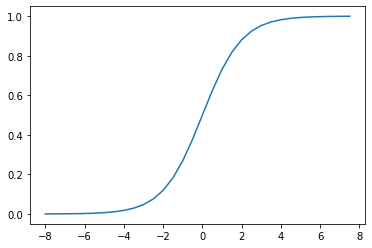

In [2]:
Y = np.arange(-8, 8, 0.5)
Ytrans = 1/(1+np.exp(-Y))
plt.plot(Y, Ytrans)

我们可以发现：

`Sigmoid` 函数决定了模型的输出在 $[0,1]$ 区间，所以逻辑回归模型可以用作区间在 $[0,1]$ 的`回归任务`，也可以用作$\{0,1\}$的`二分类任务`；同样，由于模型的输出在 $(0,1)$ 区间，所以逻辑回归模型的输出也可以看作这样的“概率”模型：

而将 $y$ 替换为线性回归模型 $w^Tx^*$（这里$x^*=[x^T,1]^T$）即可得到逻辑回归模型：

$$
f(x)=\sigma(w^Tx^*)=\frac{1}{1+e^{-(w^Tx^*)}}
$$

所以对于一次观测，获得分类 $y$ 的概率为：

$$
\begin{align}
&P(y=1|X) = f(X) \\
&P(y=0|X) = 1 - f(X)
\end{align}
$$
综上：
$$
\begin{align}
P(Y|X)& = f(X)^y(1 - f(X))^{1-y} \\
&=\prod_{i=1}^N f(x_i)^{y_i}(1-f(x_i))^{(1-y_i)}
\end{align}
$$
就得到了目标函数：
$$
J(w)=\sum\limits_{i=1}^N(y_i\log f(x_i)+(1-y_i)\log (1-f(x_i)))
$$

其中 $N$ 表示样本量，$x_i\in R^P$，$P$表示特征量，$y_i\in \{0,1\}$
所以，逻辑回归的学习目标可以通过极大似然估计（MLE，使似然 $P(Y|X)$ 尽可能大）来求解：

$$
\hat{w}=\mathop{argmax}_wJ(w)=\mathop{argmax}_w\sum\limits_{i=1}^N(y_i\log f(x_i)+(1-y_i)\log (1-f(x_i)))
$$

注意到，这个表达式是**交叉熵表达式**的相反数乘 $N$（$CE=-\frac{1}{N}\hat{w}$），我们在梯度下降中习惯于最小化一个 `loss function`，因此将其转 `CrossEntropy Loss`：

$$
L(w)=-\frac{1}{N}\mathop{argmax}_w\sum\limits_{i=1}^N(y_i\log p_1+(1-y_i)\log (1-p_1))
$$

接下求解关于 $w$ 的导数，
$$
\frac{\partial L}{\partial w}=-\sum_{i=1}^n (y_i-f(x_i))x_i^*
$$
通过梯度下降求解$w$的更新公式即可，所以$w$的更新公式：
$$
w:=w-\eta \frac{\partial L}{\partial w}
$$

## 二、代码实现

同LinearRegression类似，这里也将$L1,L2$的正则化功能加入

In [3]:
class LogisticRegression(object):
    def __init__(self, fit_intercept=True, solver='sgd', if_standard=True, l1_ratio=None, l2_ratio=None, epochs=10,
                 eta=None, batch_size=16):

        self.w = None
        self.fit_intercept = fit_intercept
        self.solver = solver
        self.if_standard = if_standard
        if if_standard:
            self.feature_mean = None
            self.feature_std = None
        self.epochs = epochs
        self.eta = eta
        self.batch_size = batch_size
        self.l1_ratio = l1_ratio
        self.l2_ratio = l2_ratio
        # 注册sign函数
        self.sign_func = np.vectorize(utils.sign)
        # 记录losses
        self.losses = []

    def init_params(self, n_features):
        """
        初始化参数
        :return:
        """
        self.w = np.random.random(size=(n_features, 1))

    def _fit_closed_form_solution(self, x, y):
        """
        直接求闭式解
        :param x:
        :param y:
        :return:
        """
        self._fit_sgd(x, y)

    def _fit_sgd(self, x, y):
        """
        随机梯度下降求解
        :param x:
        :param y:
        :return:
        """
        x_y = np.c_[x, y]
        count = 0
        for _ in range(self.epochs):
            np.random.shuffle(x_y)
            for index in range(x_y.shape[0] // self.batch_size):
                count += 1
                batch_x_y = x_y[self.batch_size * index:self.batch_size * (index + 1)]
                batch_x = batch_x_y[:, :-1]
                batch_y = batch_x_y[:, -1:]

                dw = -1 * (batch_y - utils.sigmoid(batch_x.dot(self.w))).T.dot(batch_x) / self.batch_size
                dw = dw.T

                # 添加l1和l2的部分
                dw_reg = np.zeros(shape=(x.shape[1] - 1, 1))
                if self.l1_ratio is not None:
                    dw_reg += self.l1_ratio * self.sign_func(self.w[:-1]) / self.batch_size
                if self.l2_ratio is not None:
                    dw_reg += 2 * self.l2_ratio * self.w[:-1] / self.batch_size
                dw_reg = np.concatenate([dw_reg, np.asarray([[0]])], axis=0)

                dw += dw_reg
                self.w = self.w - self.eta * dw

            # 计算losses
            cost = -1 * np.sum(
                np.multiply(y, np.log(utils.sigmoid(x.dot(self.w)))) + np.multiply(1 - y, np.log(
                    1 - utils.sigmoid(x.dot(self.w)))))
            self.losses.append(cost)

    def fit(self, x, y):
        """
        :param x: ndarray格式数据: m x n
        :param y: ndarray格式数据: m x 1
        :return:
        """
        y = y.reshape(x.shape[0], 1)
        # 是否归一化feature
        if self.if_standard:
            self.feature_mean = np.mean(x, axis=0)
            self.feature_std = np.std(x, axis=0) + 1e-8
            x = (x - self.feature_mean) / self.feature_std
        # 是否训练bias
        if self.fit_intercept:
            x = np.c_[x, np.ones_like(y)]
        # 初始化参数
        self.init_params(x.shape[1])
        # 更新eta
        if self.eta is None:
            self.eta = self.batch_size / np.sqrt(x.shape[0])

        if self.solver == 'closed_form':
            self._fit_closed_form_solution(x, y)
        elif self.solver == 'sgd':
            self._fit_sgd(x, y)

    def get_params(self):
        """
        输出原始的系数
        :return: w,b
        """
        if self.fit_intercept:
            w = self.w[:-1]
            b = self.w[-1]
        else:
            w = self.w
            b = 0
        if self.if_standard:
            w = w / self.feature_std.reshape(-1, 1)
            b = b - w.T.dot(self.feature_mean.reshape(-1, 1))
        return w.reshape(-1), b

    def predict_proba(self, x):
        """
        预测为y=1的概率
        :param x:ndarray格式数据: m x n
        :return: m x 1
        """
        if self.if_standard:
            x = (x - self.feature_mean) / self.feature_std
        if self.fit_intercept:
            x = np.c_[x, np.ones(x.shape[0])]
        return utils.sigmoid(x.dot(self.w))

    def predict(self, x):
        """
        预测类别，默认大于0.5的为1，小于0.5的为0
        :param x:
        :return:
        """
        proba = self.predict_proba(x)
        return (proba > 0.5).astype(int)

    def plot_decision_boundary(self, x, y):
        """
        绘制前两个维度的决策边界
        :param x:
        :param y:
        :return:
        """
        y = y.reshape(-1)
        weights, bias = self.get_params()
        w1 = weights[0]
        w2 = weights[1]
        bias = bias[0][0]
        x1 = np.arange(np.min(x), np.max(x), 0.1)
        x2 = -w1 / w2 * x1 - bias / w2
        plt.scatter(x[:, 0], x[:, 1], c=y, s=50)
        plt.plot(x1, x2, 'r')
        plt.show()

    def plot_losses(self):
        plt.plot(range(0, len(self.losses)), self.losses)
        plt.show()

## 三、校验

构造一批伪分类数据并可视化

In [4]:
from sklearn.datasets import make_classification
data,target=make_classification(n_samples=200, n_features=2,n_classes=2,
                                n_informative=1,n_redundant=0,n_repeated=0,
                                n_clusters_per_class=1)

In [5]:
data.shape,target.shape

((200, 2), (200,))

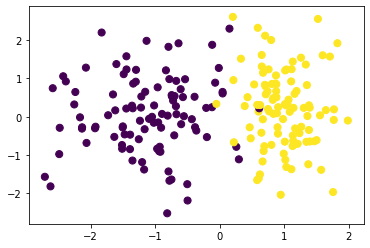

In [6]:
plt.scatter(data[:, 0], data[:, 1], c=target,s=50)

### 训练模型

In [7]:
lr = LogisticRegression(l1_ratio=0.01,l2_ratio=0.01)
lr.fit(data, target)

### 查看Loss变化

CrossEntropy 损失

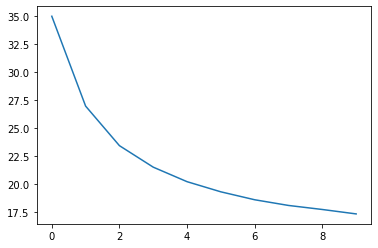

In [8]:
lr.plot_losses()

### 绘制决策边界：

令$w_1x_1+w_2x_2+b=0$，可得$x_2=-\frac{w_1}{w_2}x_1-\frac{b}{w_2}$

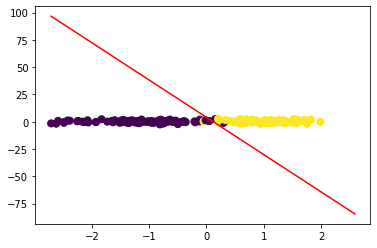

In [9]:
lr.plot_decision_boundary(data,target)

In [10]:
#计算F1
from sklearn.metrics import f1_score
f1_score(target,lr.predict(data))

0.9753694581280788

### 与sklearn对比

In [11]:
from sklearn.linear_model import LogisticRegression

In [12]:
lr = LogisticRegression()
lr.fit(data, target)

D:\Develop\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
w1=lr.coef_[0][0]
w2=lr.coef_[0][1]
bias=lr.intercept_[0]
w1,w2,bias

(3.9675370198363726, 0.06610814840933965, -0.44126681424548375)

In [14]:
x1=np.arange(np.min(data),np.max(data),0.1)
x2=-w1/w2*x1-bias/w2

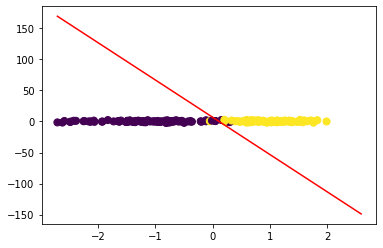

In [15]:
plt.scatter(data[:, 0], data[:, 1], c=target,s=50)
plt.plot(x1,x2,'r')

In [16]:
#计算F1
f1_score(target,lr.predict(data))

0.9753694581280788

##四.问题讨论：损失函数为何不用mse?

上面我们基本完成了二分类LogisticRegression代码的封装工作，并将其放到linermodel模块方便后续使用，接下来我们讨论一下模型中损失函数选择的问题；在前面线性回归模型中我们使用了mse作为损失函数，并取得了不错的效果，而逻辑回归中使用的确是交叉熵损失函数；这是因为如果使用mse作为损失函数,梯度下降将会比较困难，在$f(x^i)$与$y^i$相差较大或者较小时梯度值都会很小，下面推导一下：
我们令：
$$
L(w)=\frac{1}{2}\sum&lt;/em&gt;{i=1}^n(y^i-f(x^i))^2
$$
则有：
$$
\frac{\partial L}{\partial w}=\sum_{i=1}^n(f(x^i)-y^i)f(x^i)(1-f(x^i))x^i
$$我们简单看两个极端的情况： （1）$y^i=0,f(x^i)=1$时，$\frac{\partial L}{\partial w}=0$； （2）$y^i=1,f(x^i)=0$时，$\frac{\partial L}{\partial w}=0$ 接下来，我们绘图对比一下两者梯度变化的情况，假设在$y=1,x\in(-10,10),w=1,b=0$的情况下

In [17]:
y=1
x0=np.arange(-10,10,0.5)
#交叉熵
x1=np.multiply(utils.sigmoid(x0)-y,x0)

In [18]:
#mse
x2=np.multiply(utils.sigmoid(x0)-y,utils.sigmoid(x0))
x2=np.multiply(x2,1-utils.sigmoid(x0))
x2=np.multiply(x2,x0)

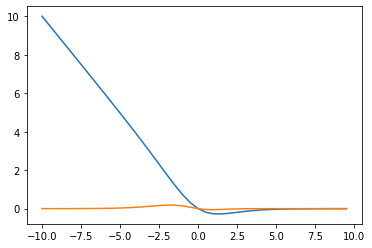

In [19]:
plt.plot(x0,x1)
plt.plot(x0,x2)

可见在错分的那一部分（x<0）,mse的梯度值基本停留在0附近，而交叉熵会让越“错”情况具有越大的梯度值（这里称呼梯度值不准确，你明白意思就行~）